In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
#label_to_index = {'Bhoopali': 0, 'Yaman': 1, 'Bhairava': 2}
df = pd.read_csv('audio_features_dataset.csv')

In [6]:
hop_length = 512
sampling_rate = 22050

In [10]:
feature_cols = [col for col in df.columns if col.startswith('mfcc_')]
X = df[feature_cols].values
y = df['Ragas'].values
print("Shape of X before reshape:", X.shape)
print("Shape of y before encode:", y.shape)


Shape of X before reshape: (92, 40)
Shape of y before encode: (92,)


In [9]:
# Get the number of MFCC features
num_mfcc = 40
num_time_frames = X.shape[1] // num_mfcc
print(num_time_frames)

1


In [11]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes=num_classes)
print("Shape of y_categorical before split:", y_categorical.shape)

Shape of y_categorical before split: (92, 3)


In [13]:
originallabels = label_encoder.classes_
print("Original labels: ", originallabels)
print("Encoded labels: ", np.unique(y_encoded))

Original labels:  ['Bhairava' 'Bhoopali' 'Yaman']
Encoded labels:  [0 1 2]


In [ ]:
#X_reshaped_2d = X.reshape((-1, time_step, num_mfcc))
X_reshaped = X_scaled.reshape(-1, num_mfcc, num_time_frames, 1)
#print("Shape of X_reshaped_2d before split:", X_reshaped_2d.shape)

In [56]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=127)
X_train_flat = np.array([x.flatten() for x in X_train])
le = LabelEncoder()
y_train_numerical = le.fit_transform(y_train)
y_val_numerical = le.transform(y_val)
y_train_encoded = to_categorical(y_train_numerical, num_classes=num_classes)
y_val_encoded = to_categorical(y_val_numerical, num_classes=num_classes)

In [58]:
print(y_val_encoded)

[[1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [49]:
print(X_train[0])
print(X_train_flat[0])

[-2.5962530e+02  2.0785226e+02 -2.2729885e+01  2.0551851e+01
  2.0046564e+01 -9.0151350e+00 -4.4524753e-01 -4.6271220e+00
 -5.6103706e+00 -5.6083555e+00 -9.9795030e+00 -7.0625763e+00
 -6.0602140e+00 -5.5142410e+00 -5.1507034e+00 -4.0491443e+00
 -3.6882331e+00 -1.0860273e+01 -6.7144060e+00 -8.3063140e+00
 -1.8581013e+01 -9.0850520e+00 -2.6255262e+00 -5.3334440e+00
 -5.0252400e+00 -7.8971586e+00 -7.5272620e+00 -5.8563880e+00
 -8.3133070e+00 -5.5964140e+00  9.6105370e-01 -8.0614360e-02
 -2.2270885e+00 -2.1927805e+00 -3.6106818e+00 -2.4475093e+00
 -5.7229686e+00 -8.8137970e+00 -7.4188895e+00 -5.5039463e+00]
[-2.5962530e+02  2.0785226e+02 -2.2729885e+01  2.0551851e+01
  2.0046564e+01 -9.0151350e+00 -4.4524753e-01 -4.6271220e+00
 -5.6103706e+00 -5.6083555e+00 -9.9795030e+00 -7.0625763e+00
 -6.0602140e+00 -5.5142410e+00 -5.1507034e+00 -4.0491443e+00
 -3.6882331e+00 -1.0860273e+01 -6.7144060e+00 -8.3063140e+00
 -1.8581013e+01 -9.0850520e+00 -2.6255262e+00 -5.3334440e+00
 -5.0252400e+00 -7.8971

In [ ]:
# Split data
#X_train, X_temp, y_train, y_temp = train_test_split(X_reshaped_2d, y_categorical, test_size=0.3, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#print("Shape of X_train:", X_train.shape)
#print("Shape of y_train:", y_train.shape)
#print("Number of classes:", num_classes)

Shape of X_train: (64, 40)
Shape of y_train: (64, 3)
Number of classes: 3


In [59]:
# Build the CNN model
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(32, 3, activation='relu', input_shape=(input_shape, 1)),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [60]:
input_shape = X_train_flat.shape[1]
model = create_cnn_model(input_shape, num_classes)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [61]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 38, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 17, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,363 (153.76 KB)

 Trainable params: 39,363 (153.76 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# Train the model
history = model.fit(X_train, y_train_encoded, epochs=20, validation_data=(X_val, y_val_encoded))

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - accuracy: 0.3842 - loss: 3.0781 - val_accuracy: 0.4737 - val_loss: 1.0088
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4018 - loss: 1.3555 - val_accuracy: 0.4737 - val_loss: 1.7759
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6227 - loss: 1.4206 - val_accuracy: 0.8421 - val_loss: 0.3908
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7536 - loss: 0.5312 - val_accuracy: 0.6842 - val_loss: 0.5904
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6364 - loss: 0.8015 - val_accuracy: 0.9474 - val_loss: 0.3646
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9521 - loss: 0.3068 - val_accuracy: 0.6316 - val_loss: 0.6103
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7400 - loss: 0.4829 - val_accuracy: 0.8947 - val_loss: 0.3245
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9384 - loss: 0.2359 - val_accuracy: 0.9474 - val_loss: 0.1840

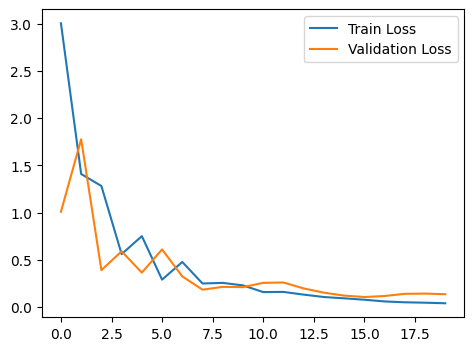

In [63]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

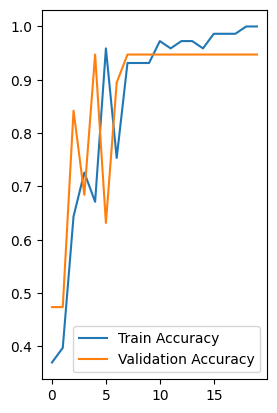

In [64]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()